Load the data set

In [4]:
%run datasetup.py


	Data Set Information:

	This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). 
	Notes: 
	1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. 
	2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.


	Attribute Information:

	1.date: Date in format dd/mm/yyyy 
	2.time: time in format hh:mm:ss 
	3.global_active_power: household global minute-averaged active power (in kilowatt) 
	4.global

import statements

In [5]:
import pandas as pd
%matplotlib notebook
import zipfile

Let's inspect the zipfile

In [6]:
fname = 'data/household_power_consumption.zip'
with zipfile.ZipFile(fname, mode = 'r') as fpzip:
    print(fpzip.infolist())
    print(fpzip.namelist())
    with fpzip.open(fpzip.namelist()[0],'r') as fp:
        counter = 0
        for line in fp:
            print(line)
            counter += 1
            if counter == 5:
                break

[<ZipInfo filename='household_power_consumption.txt' compress_type=deflate filemode='-rw-rw-r--' file_size=132960755 compress_size=20640722>]
['household_power_consumption.txt']
b'Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3\r\n'
b'16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000\r\n'
b'16/12/2006;17:25:00;5.360;0.436;233.630;23.000;0.000;1.000;16.000\r\n'
b'16/12/2006;17:26:00;5.374;0.498;233.290;23.000;0.000;2.000;17.000\r\n'
b'16/12/2006;17:27:00;5.388;0.502;233.740;23.000;0.000;1.000;17.000\r\n'


There is only one file in the zip archive so Let's try to read it with pandas

In [ ]:
df = pd.read_csv(fname, sep=';', compression='zip', nrows=10000)
df.head()

Let's compute the memory of the full dataset

In [ ]:
dftmp = pd.read_csv(fname, sep=';', compression='zip')
print(f'Size of data in memory: {dftmp.memory_usage(deep=True).sum() * 1.e-9} GB')
print(dftmp.shape)
del dftmp

Let's improve the csv reading

In [ ]:
df = pd.read_csv(
    fname,
    sep=';',
    compression='zip',
    parse_dates={'ts':['Date','Time']},
    index_col='ts',
    dayfirst=True,
    na_values='?'
)
df.head()

In [ ]:
df.index

In [ ]:
df.isnull().any()

In [ ]:
df.dtypes

How is the voltage distribution hourly?

<IPython.core.display.Javascript object>


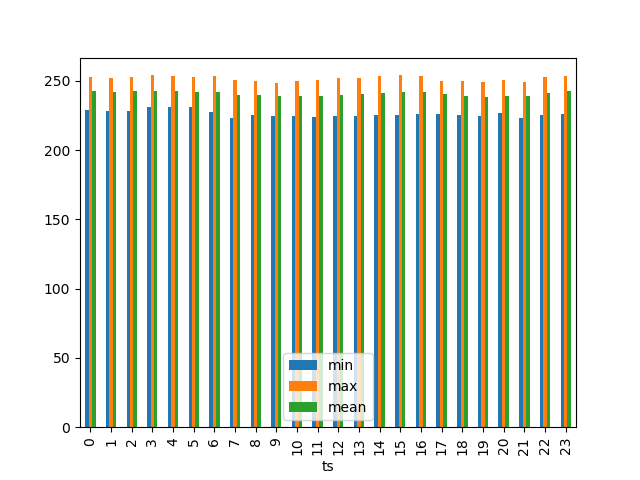

CPU times: user 4min 4s, sys: 700 ms, total: 4min 5s
Wall time: 4min 5s


In [12]:
%%time
df = pd.read_csv(
        fname,
        sep=';',
        compression='zip',
        parse_dates={'ts':['Date','Time']},
        dayfirst=True,
        na_values='?'
    )
df = (
    df.groupby(df.ts.dt.hour)['Voltage']
    .agg(['min', 'max', 'mean'])
)
df.plot.bar()

Let's try with dask

In [1]:
import dask.dataframe as dd

/home/srg/miniconda3/lib/python3.7/site-packages/dask/dataframe/io/csv.py:389: UserWarning: Warning zip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  "Setting ``blocksize=None``" % compression


<IPython.core.display.Javascript object>


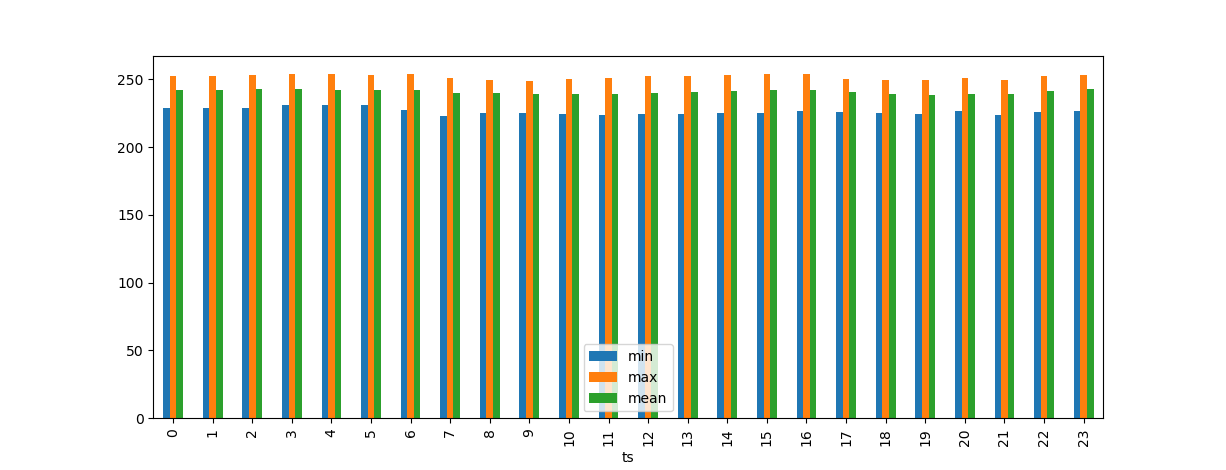

CPU times: user 2min 41s, sys: 588 ms, total: 2min 42s
Wall time: 2min 41s


In [10]:
%%time
df = dd.read_csv(
        fname,
        sep=';',
        compression='zip',
        parse_dates={'ts':['Date','Time']},
        dayfirst=True,
        na_values='?'
    )
df = (
    df.groupby(df.ts.dt.hour)['Voltage']
    .agg(['min', 'max', 'mean'])
    .compute()
)
df.plot.bar()